In [161]:
%load_ext autoreload
%autoreload 1
%aimport vae
%aimport distributions
%aimport distribution_metrics
%aimport y_utils
%aimport samplers
%aimport utilities
from utilities import *
from y_utils import *
from vae import VAE, get_filename
from samplers import *
from distributions import Banana, Funnel, create_gaussian_lattice, create_random_gaussian_mixture
from distribution_metrics import *
import torch
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from time import time
from tqdm import tqdm
from collections import defaultdict
from math import ceil

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [162]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)

device: cuda


**Target 1**

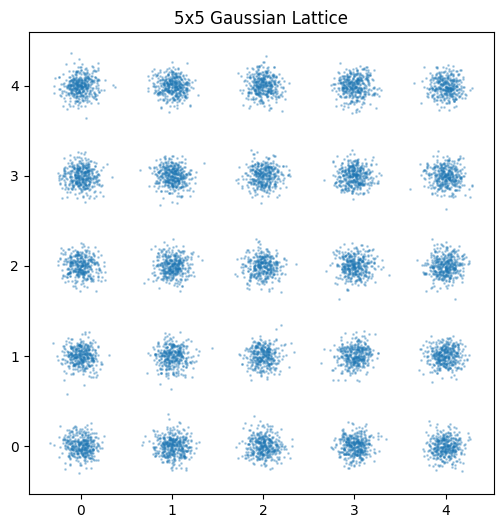

In [163]:
lattice_shape = (5, 5)
D = len(lattice_shape)
mode_variance = 0.01
target = create_gaussian_lattice(lattice_shape, 1, mode_variance, device=device)
target_name = f'gaussian_lattice{lattice_shape}_var{mode_variance}'
target_friendly_name = f'{"x".join(map(str, lattice_shape))} Gaussian Lattice'

target_samples = target.sample((10000,))
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(*pl(target_samples), s=1, alpha=0.3)
ax.set_title(target_friendly_name);

**Target 2**

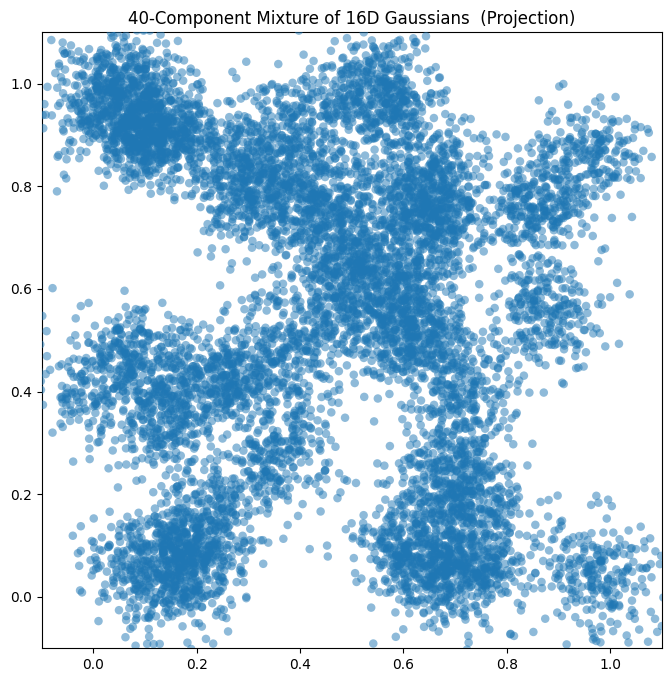

In [211]:
mean_lim = np.array([0, 1])
seed = 46
n_components = 40
D = 16
variance_lim = (0.0005, 0.005)
target = create_random_gaussian_mixture(dim=D, n_components=n_components, mean_lim=mean_lim, variance_lim=variance_lim, device=device, seed=seed)
target_name = f'mog{n_components}_{D}d_vlim{variance_lim}_seed{seed}'
target_friendly_name = f'{n_components}-Component Mixture of {D}D Gaussians'


def plot_mog_target():
    N = 10_000
    plot_lim = (-0.1, 1.1)
    d = 200

    fig, ax = plt.subplots(figsize=(8, 8))

    # contour plot
    if D == 2:
        x = torch.linspace(*plot_lim, d)
        y = torch.linspace(*plot_lim, d)
        X, Y = torch.meshgrid(x, y, indexing='ij')
        points = torch.vstack((X.ravel(), Y.ravel()))
        Z = target.log_prob(points.T.to(device)).reshape(d, d)
        ax.contour(to_numpy(X), to_numpy(Y), to_numpy(Z), levels=30)

    # Implementation of torch.distributions.mixture_same_family.sample() causes MemoryOverflow without batched sampling
    target_sample = sample_by_batches(target, N, batch_size=1024)
    
    if D > 2:
        proj_dims = (0, 1)
        target_sample = target_sample[:, proj_dims]
    ax.scatter(*pl(target_sample), zorder=4, alpha=0.5, s=150, edgecolors='none', marker='.')
    ax.set_xlim(*plot_lim)
    ax.set_ylim(*plot_lim)
    ax.set_title(f'{target_friendly_name} {" (Projection)" if D > 2 else ""}')


plot_mog_target()
torch.cuda.empty_cache()

In [212]:
hidden_dims = (64, 64, 64, 64)
model = VAE(
    data_dim=D,
    hidden_dims=hidden_dims,
    latent_dim=D,
    device=device
)
model_filename = f'models/{target_name}_hdim{hidden_dims}_vae'

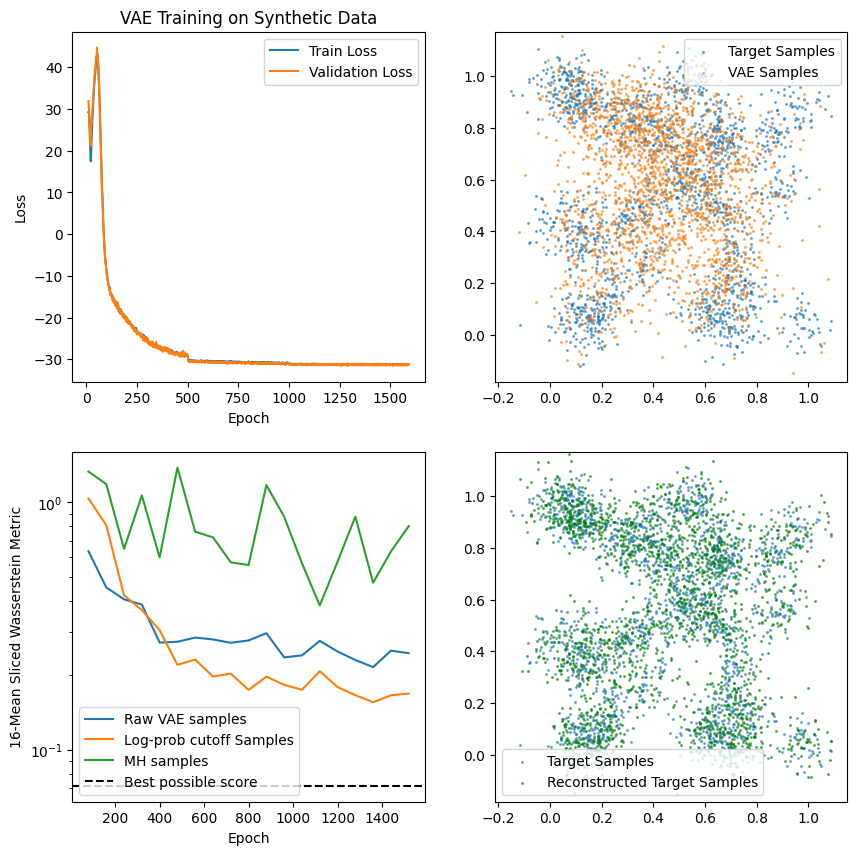

Epoch 1590
	Train loss: -31.2048
	Validation loss: -31.2528
	Learning rate: 5e-06
MH discarded 0 outlier(s)


In [213]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.1, step_size=500)
model.fit_distribution(
    target, 16_384, optimizer,
    scheduler=scheduler, max_epochs=1600,
    no_kl_penalty_epochs=50,
    kl_annealing_epochs=300, batch_size=2_048,
    distribution_metric=SlicedDistributionMetric(WassersteinMetric1d(), D)
)

In [215]:
model.save_knowledge(model_filename)

In [103]:
model.load_knowledge(model_filename)
model.set_std_factor(1)

In [201]:
L = 512
beta = 1
model_log_prob_estimator = lambda x : model.iw_log_marginal_estimate(x, L=L, beta=beta, batch_L=32)
dummy_estimator = lambda x: torch.ones(x.shape[0])

def get_density_ratios(samples):
    return target.log_prob(samples) - model_log_prob_estimator(samples)

CPU times: total: 3.17 s
Wall time: 3.19 s


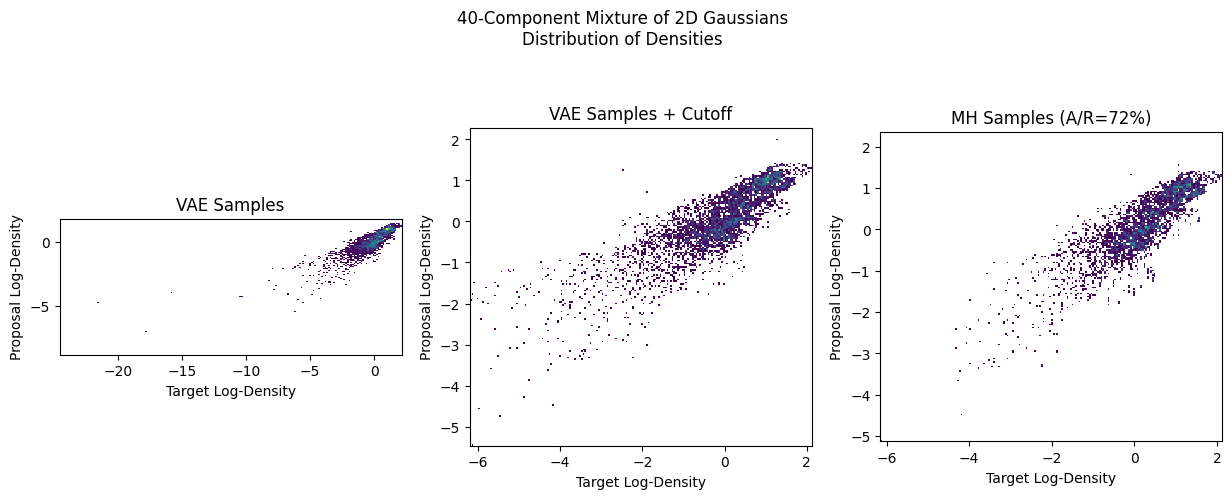

In [192]:
%%time

def plot_densities_distributions():
    N = 5000
    q = 0.0
    target_samples = target.sample((N,))
    target_quantile = target.log_prob(target_samples).quantile(q)
    model_samples = model.sample((N,))
    
    dr_q = 0.005
    model_density_ratios = get_density_ratios(model_samples)
    #max_density_ratio = model_density_ratios.quantile(1 - dr_q)
    #dr_cutoff = 5
    max_density_ratio = 5
    model_samples = model_samples[model_density_ratios < max_density_ratio]

    cut_acc_rate, cut_samples = log_prob_cutoff_filter(target, model_samples, target_quantile, return_indicies=False)
    mh_acc_rate, mh_samples = metropolis_hastings_filter(target, cut_samples, model_log_prob_estimator, n_estimates=10, return_indicies=False)

    plot_info = [
        ('VAE Samples', model_samples),
        ('VAE Samples + Cutoff', cut_samples),
        (f'MH Samples (A/R={100*mh_acc_rate:0.0f}%)', mh_samples)
    ]
    
    fig, axs = plt.subplots(figsize=(15, 5), ncols=len(plot_info))
    #plt.tight_layout()
    #ax.set_xlim(left=ll_cutoff, right=torch.cat((mh_density_ratios, cut_density_ratios, model_density_ratios)).max().item()+1)
    
    ll_cutoff = -100
    for ax, (sample_name, samples) in zip(axs, plot_info):
        samples = samples[target.log_prob(samples) > ll_cutoff]
        ax.hist2d(
            to_numpy(target.log_prob(samples)),
            to_numpy(model_log_prob_estimator(samples)),
            bins=200,
            density=False,
            cmin=1,
        )
        filter_line_xs = np.array([5, 25])
        ax.plot(filter_line_xs, filter_line_xs - max_density_ratio, color='red', linewidth=1)
        ax.set_xlabel('Target Log-Density')
        ax.set_ylabel('Proposal Log-Density')
        ax.set_title(sample_name)
        ax.set_aspect('equal')

    fig.suptitle(f'{target_friendly_name}\nDistribution of Densities', y=1.05)

plot_densities_distributions()

3it [00:00, 27.27it/s]

MH discarded 0 outlier(s)
MH discarded 0 outlier(s)


6it [00:20,  3.41s/it]


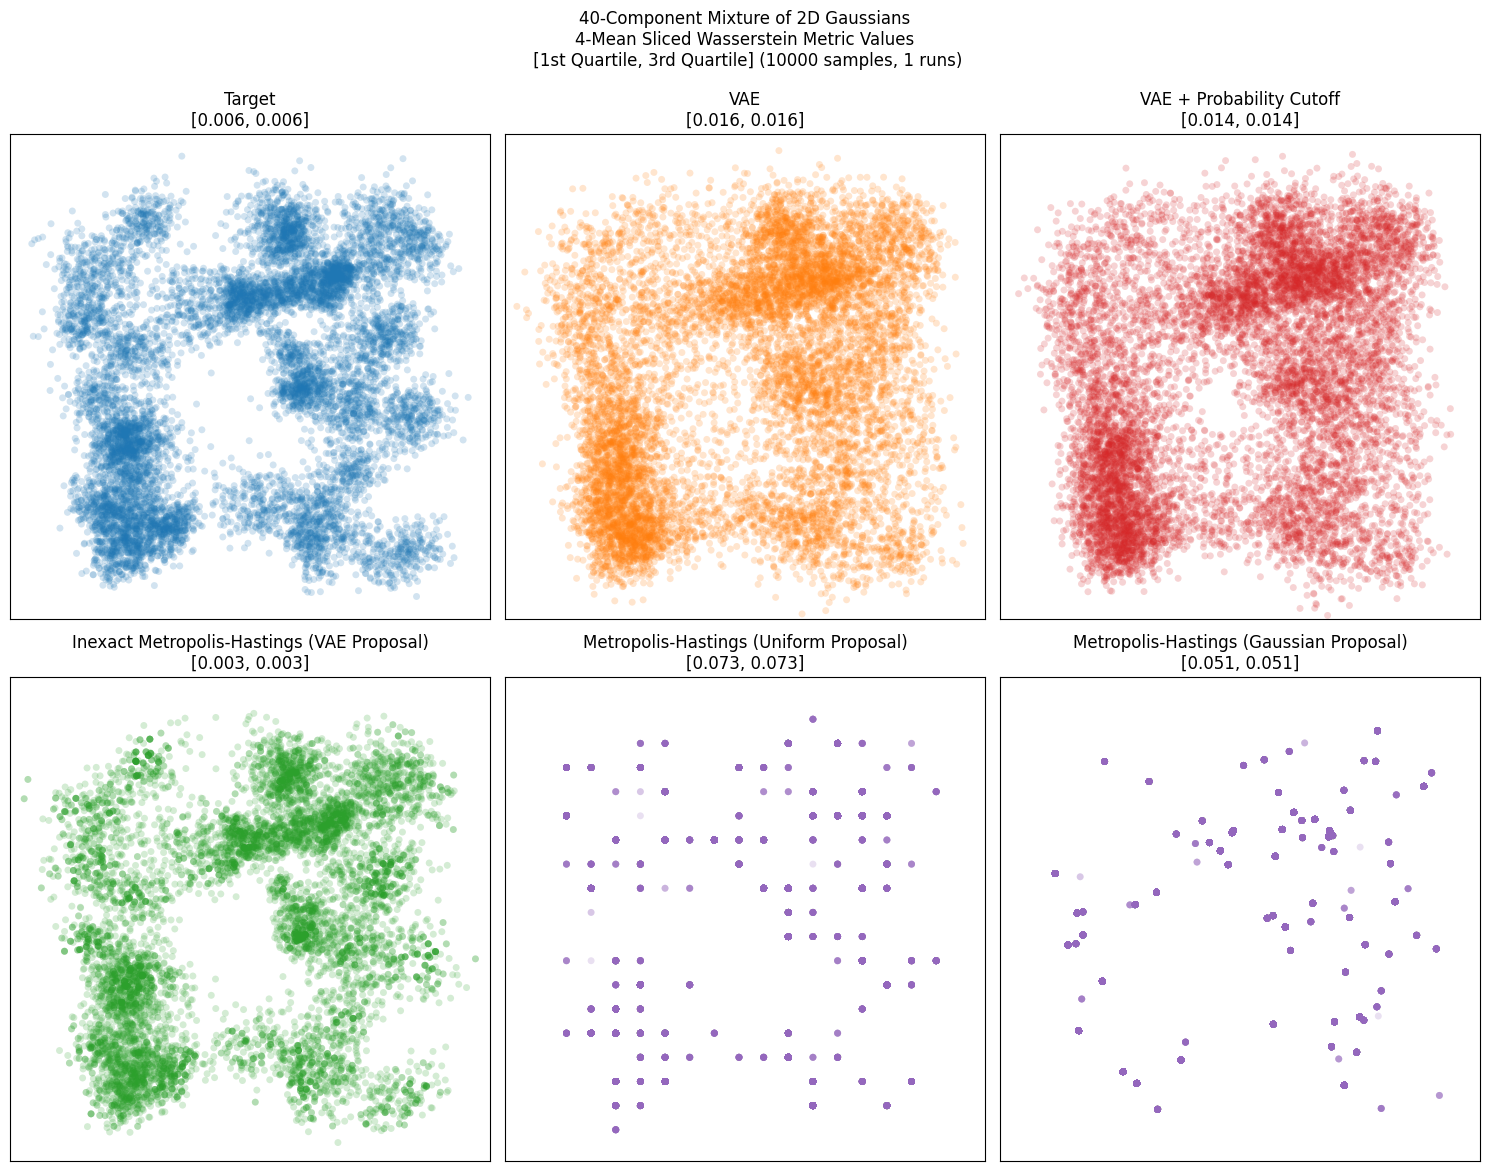

In [202]:
def plot_samples():
    metric = SlicedDistributionMetric(WassersteinMetric1d(), 4)
    #metric = WassersteinMetric()
    N = 10_000
    q = 0
    n_runs = 1
    max_rejections=None
    n_estimates = 10
    
    target_samples = target.sample((N,))
    target_quantile = target.log_prob(target_samples).quantile(q)
    # model_samples = model.sample((N,))

    dr_q = 0.015
    # model_density_ratios = get_density_ratios(model_samples)
    #max_density_ratio = model_density_ratios.quantile(1 - dr_q)
    max_density_ratio = 6.5

    # Wrapped in a functions to allow multiple runs
    def get_cut_samples():
        return log_prob_cutoff_filter(target, model.sample((N,)), target_quantile, return_indicies=False)[1]
    def get_mh_samples():
        cut_samples = get_cut_samples()
        # cut_density_ratios = get_density_ratios(cut_samples)
        # cut_samples = cut_samples[cut_density_ratios < max_density_ratio]
        return metropolis_hastings_filter(target, cut_samples, model_log_prob_estimator, n_estimates=n_estimates, max_density_ratio=max_density_ratio, return_indicies=False)[1]
    def get_uni_mh_samples():
        return metropolis_hastings_filter(target, uniform_samples, dummy_estimator, return_indicies=False)[1]
    def get_gaussian_mh_samples():
        gaussian_prop = torch.distributions.MultivariateNormal(torch.zeros(2, device=device) + 2, torch.eye(2, device=device))
        return metropolis_hastings_filter(target, gaussian_prop.sample((N,)), gaussian_prop.log_prob, return_indicies=False)[1]

    plot_info = [
        (lambda: target.sample((N,)), 'Target', 'tab:blue'),
        (lambda: model.sample((N,)), 'VAE', 'tab:orange'),
        (get_cut_samples, 'VAE + Probability Cutoff', 'tab:red'),
        (get_mh_samples, 
         f'Inexact Metropolis-Hastings (VAE Proposal)', 
         'tab:green'),
    ]
    if D == 2:
        plot_lim = (-1, 6)
        coord_values = [torch.linspace(*plot_lim, ceil(N ** (1 / D)))] * D
        grid_coords = torch.meshgrid(*coord_values, indexing='ij')
        uniform_samples = torch.vstack(tuple(map(torch.ravel, grid_coords))).T[torch.randperm(N)].to(device)
        plot_info.append((get_uni_mh_samples, 'Metropolis-Hastings (Uniform Proposal)', 'tab:purple'))
        plot_info.append((get_gaussian_mh_samples, 'Metropolis-Hastings (Gaussian Proposal)', 'tab:purple'))
        proj_vecs = torch.eye(2, device=device)
    else:
        proj_vecs = torch.qr(torch.randn(D, D, device=device, generator=torch.Generator(42))).Q[:2]
    
    fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(15, 11))
    axs = axs.flatten()
    for i, (get_samples, sample_name, color) in tqdm(enumerate(plot_info)):
        #metric_mean, metric_std = estimate_mean_and_std(lambda: metric(target.sample((N,)), get_samples()), n_runs=10)
        metric_lower, metric_upper = estimate_quartiles(lambda: metric(target.sample((N,)), get_samples()), n_runs=n_runs)
        axs[i].scatter(*pl(get_samples() @ proj_vecs.T), s=100, alpha=0.2, edgecolors='none', marker='.', c=color)
        axs[i].set_title(f'{sample_name}\n[{metric_lower:0.3f}, {metric_upper:0.3f}]')
    for ax in axs:
        #ax.axis('equal')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlim(axs[0].get_xlim())
        ax.set_ylim(axs[0].get_ylim())
    plt.tight_layout()
    # Mean ± Std Dev
    fig.suptitle(f'{target_friendly_name}\n{metric.name()} Values\n [1st Quartile, 3rd Quartile] ({N} samples, {n_runs} runs)', y=1.06)

plot_samples()

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [12:25<00:00, 37.26s/it]


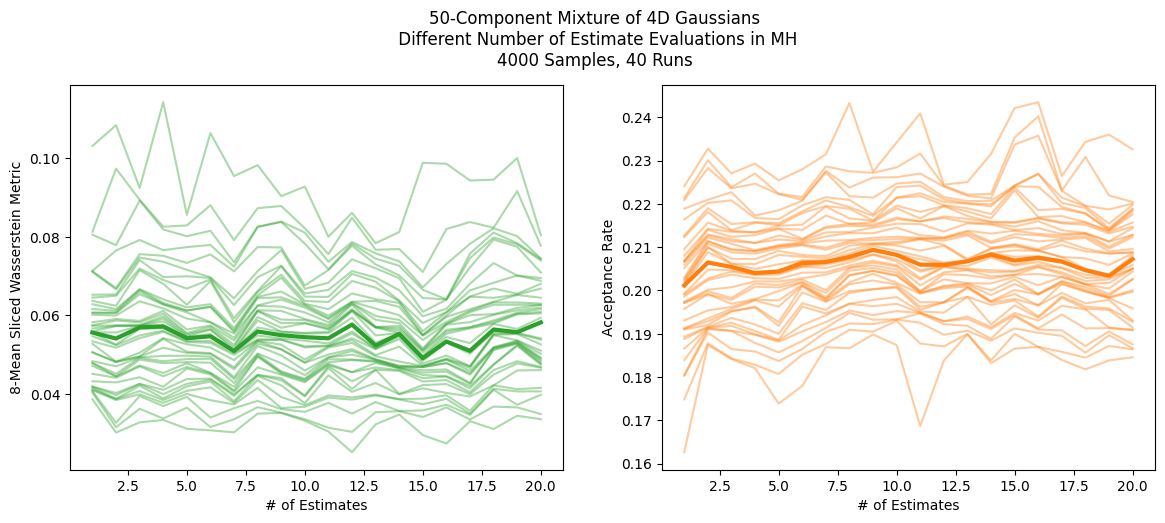

In [58]:
def find_optimal_n_estimates():
    metric = SlicedDistributionMetric(WassersteinMetric1d(), 8)
    # metric = WassersteinMetric()
    N = 4000
    n_estimates_options = np.arange(1, 21)
    n_runs = 40
    q = 0.0
    target_samples = target.sample((N,))
    target_quantile = target.log_prob(target_samples).quantile(q)

    mh_metrics = []
    mh_acc_rates = []
    for n_estimates in tqdm(n_estimates_options):
        mh_metrics.append([])
        mh_acc_rates.append([])
        for i in range(n_runs):
            model_samples = model.sample((N,))
            cut_acc_rate, cut_samples = log_prob_cutoff_filter(target, model_samples, target_quantile, return_indicies=False)
            mh_acc_rate, mh_samples = metropolis_hastings_filter(target, cut_samples, model_log_prob_estimator, n_estimates=n_estimates, return_indicies=False)
            mh_metrics[-1].append(metric(target.sample((N,)), mh_samples).item())
            mh_acc_rates[-1].append(mh_acc_rate)

    def plot(ax_num, values, *args, **kwargs):
        values = np.array(values)
        values.sort()
        median_values = np.median(values, axis=-1)
        for i in range(values.shape[1]):
            axs[ax_num].plot(n_estimates_options, values[:, i], alpha=0.4, *args, **kwargs)
        axs[ax_num].plot(n_estimates_options, median_values, linewidth=3, *args, **kwargs)
    fig, axs = plt.subplots(ncols=2, figsize=(14, 5))
    plot(0, mh_metrics, color='tab:green')
    # axs[0].set_title()
    axs[0].set_xlabel('# of Estimates')
    axs[0].set_ylabel(f'{metric.name()}')
    plot(1, mh_acc_rates, color='tab:orange')
    axs[1].set_xlabel('# of Estimates')
    axs[1].set_ylabel(f'Acceptance Rate')
    #plt.tight_layout()
    fig.suptitle(f'{target_friendly_name}\n Different Number of Estimate Evaluations in MH\n{N} Samples, {n_runs} Runs', y=1.03)

find_optimal_n_estimates()

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [08:58<00:00, 25.63s/it]


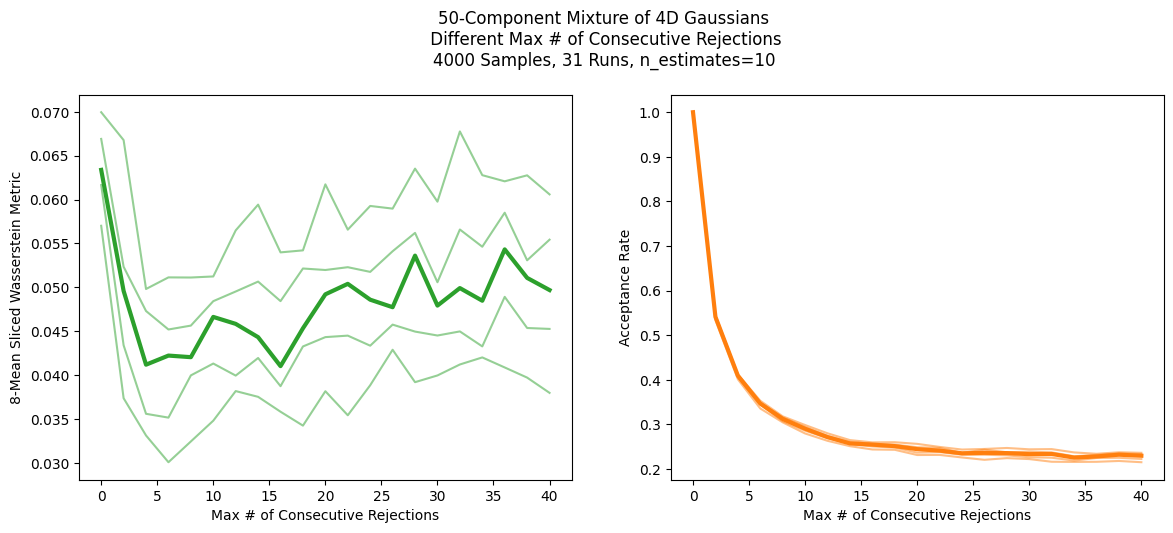

In [65]:
def find_optimal_max_rejections():
    metric = SlicedDistributionMetric(WassersteinMetric1d(), 8)
    #metric = WassersteinMetric()
    N = 4000
    q = 0.0
    max_rejections_options = np.arange(0, 41, 2)
    n_runs = 31
    n_estimates = 10
    
    target_samples = target.sample((N,))
    target_quantile = target.log_prob(target_samples).quantile(q)
    
    mh_metrics = []
    mh_acc_rates = []
    for max_rejections in tqdm(max_rejections_options):
        mh_metrics.append([])
        mh_acc_rates.append([])
        for i in range(n_runs):
            model_samples = model.sample((N,))
            cut_acc_rate, cut_samples = log_prob_cutoff_filter(target, model_samples, target_quantile, return_indicies=False)
            mh_acc_rate, mh_samples = metropolis_hastings_filter(target, cut_samples, model_log_prob_estimator, n_estimates=10, max_rejections=max_rejections, return_indicies=False)
            mh_metrics[-1].append(metric(target.sample((N,)), mh_samples).item())
            mh_acc_rates[-1].append(mh_acc_rate)

    def plot(ax_num, values, *args, **kwargs):
        values = np.array(values)
        mean_values = np.median(values, axis=-1)
        values.sort()
        for i in [5, 10, 20, 25]:
            axs[ax_num].plot(max_rejections_options, values[:, i], alpha=0.5, *args, **kwargs)
        axs[ax_num].plot(max_rejections_options, mean_values, linewidth=3, *args, **kwargs)
    fig, axs = plt.subplots(ncols=2, figsize=(14, 5))
    plot(0, mh_metrics, color='tab:green')
    # axs[0].set_title()
    axs[0].set_xlabel('Max # of Consecutive Rejections')
    axs[0].set_ylabel(f'{metric.name()}')
    plot(1, mh_acc_rates, color='tab:orange')
    axs[1].set_xlabel('Max # of Consecutive Rejections')
    axs[1].set_ylabel(f'Acceptance Rate')
    #plt.tight_layout()
    fig.suptitle(f'{target_friendly_name}\n Different Max # of Consecutive Rejections\n{N} Samples, {n_runs} Runs, n_estimates={n_estimates}', y=1.05)

find_optimal_max_rejections()

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [05:28<00:00, 32.84s/it]


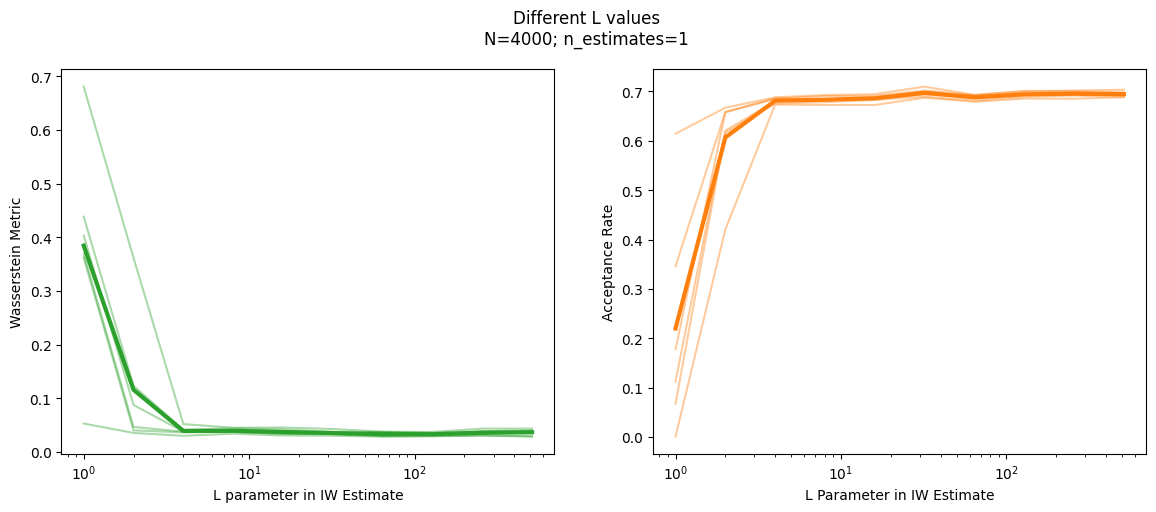

In [34]:
def find_optimal_L():
    # metric = SlicedDistributionMetric(WassersteinMetric1d(), 24)
    metric = WassersteinMetric()
    N = 4000
    q = 0.0
    L_options = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
    n_runs = 6
    n_estimates = 1
    
    target_samples = target.sample((N,))
    model_samples = model.sample((N,))
    target_quantile = target.log_prob(target_samples).quantile(q)
    cut_acc_rate, cut_samples = log_prob_cutoff_filter(target, model_samples, target_quantile, return_indicies=False)

    mh_metrics = []
    mh_acc_rates = []
    for L in tqdm(L_options):
        mh_metrics.append([])
        mh_acc_rates.append([])
        model_log_prob_estimator = lambda x : model.iw_log_marginal_estimate(x, L=L, beta=beta, batch_L=32)
        for i in range(n_runs):
            mh_acc_rate, mh_samples = metropolis_hastings_filter(target, cut_samples, model_log_prob_estimator, n_estimates=n_estimates, return_indicies=False)
            mh_metrics[-1].append(metric(target_samples, mh_samples).item())
            mh_acc_rates[-1].append(mh_acc_rate)

    def plot(ax_num, x, ys, *args, **kwargs):
        ys = np.array(ys)
        ys.sort()
        mean_ys = ys.mean(axis=-1)
        for i in range(ys.shape[1]):
            axs[ax_num].plot(x, ys[:, i], alpha=0.4, *args, **kwargs)
        axs[ax_num].plot(x, mean_ys, linewidth=3, *args, **kwargs)
    
    fig, axs = plt.subplots(ncols=2, figsize=(14, 5))
    plot(0, L_options, mh_metrics, color='tab:green')
    # axs[0].set_title()
    axs[0].set_xlabel('L parameter in IW Estimate')
    axs[0].set_ylabel(f'{metric.name()}')
    plot(1, L_options, mh_acc_rates, color='tab:orange')
    axs[1].set_xlabel('L Parameter in IW Estimate')
    axs[1].set_ylabel(f'Acceptance Rate')
    for ax in axs:
        ax.set_xscale('log')
    #plt.tight_layout()
    fig.suptitle(f'Different L values\nN={N}; n_estimates={n_estimates}', y=1)

find_optimal_L()

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

MH discarded 0 outlier(s)
MH discarded 0 outlier(s)
MH discarded 0 outlier(s)
MH discarded 0 outlier(s)
MH discarded 0 outlier(s)
MH discarded 0 outlier(s)
MH discarded 0 outlier(s)
MH discarded 0 outlier(s)
MH discarded 0 outlier(s)
MH discarded 0 outlier(s)


 25%|████████████████████▊                                                              | 1/4 [04:06<12:20, 246.92s/it]

MH discarded 0 outlier(s)
MH discarded 0 outlier(s)
MH discarded 0 outlier(s)
MH discarded 0 outlier(s)
MH discarded 0 outlier(s)
MH discarded 0 outlier(s)
MH discarded 0 outlier(s)
MH discarded 0 outlier(s)
MH discarded 0 outlier(s)
MH discarded 0 outlier(s)


 50%|█████████████████████████████████████████▌                                         | 2/4 [07:55<07:52, 236.10s/it]

MH discarded 0 outlier(s)
MH discarded 0 outlier(s)
MH discarded 0 outlier(s)
MH discarded 0 outlier(s)
MH discarded 0 outlier(s)
MH discarded 0 outlier(s)
MH discarded 0 outlier(s)
MH discarded 0 outlier(s)
MH discarded 0 outlier(s)
MH discarded 0 outlier(s)


 75%|██████████████████████████████████████████████████████████████▎                    | 3/4 [09:41<02:56, 176.79s/it]

MH discarded 12 outlier(s)
MH discarded 10 outlier(s)
MH discarded 11 outlier(s)
MH discarded 6 outlier(s)
MH discarded 4 outlier(s)
MH discarded 7 outlier(s)
MH discarded 8 outlier(s)
MH discarded 9 outlier(s)
MH discarded 14 outlier(s)
MH discarded 11 outlier(s)


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [10:42<00:00, 160.50s/it]


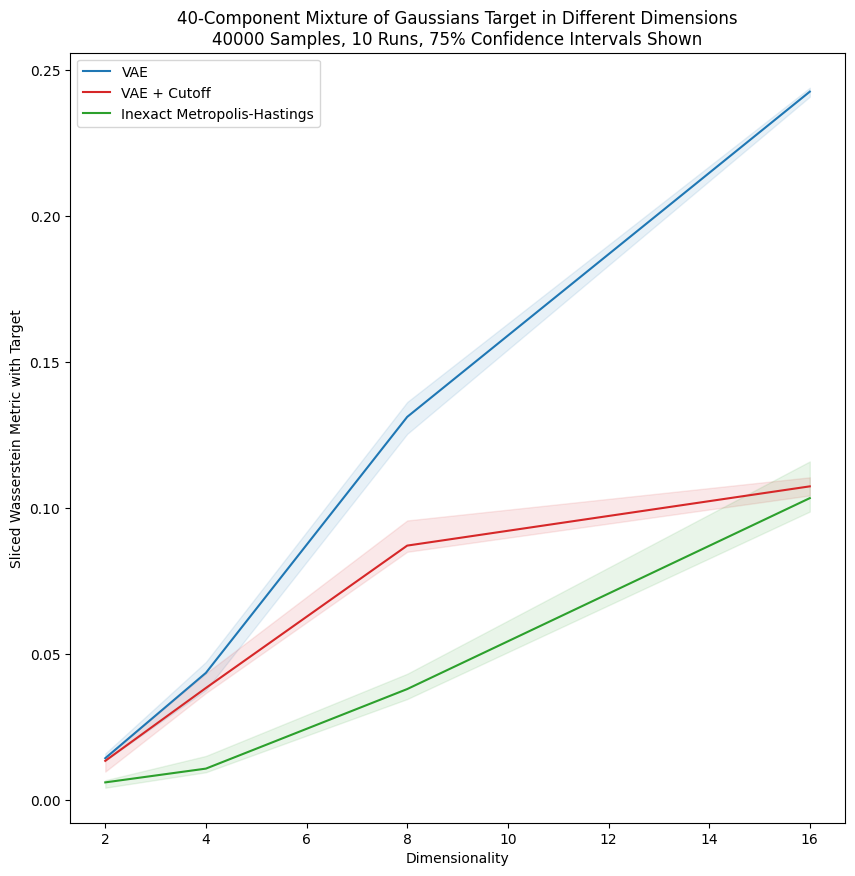

In [235]:
def plot_mog_scaling():
    # Target & model parameters
    mean_lim = np.array([0, 1])
    seed = 46
    n_components = 40
    variance_lim = (0.0005, 0.005)
    D_options = [2, 4, 8, 16]
    hidden_dims = (64, 64, 64, 64)
    N = 40_000

    # Estimator parameters
    L = 512
    beta = 1
    
    # MH parameters
    q = 0
    n_estimates = 10
    max_density_ratio = 5.5

    # Evaluation
    n_runs = 10
    model_metrics = []
    cut_metrics = []
    mh_metrics = []

    for D in tqdm(D_options):
        target = create_random_gaussian_mixture(dim=D, n_components=n_components, mean_lim=mean_lim, variance_lim=variance_lim, device=device, seed=seed)
        target_name = f'mog{n_components}_{D}d_vlim{variance_lim}_seed{seed}'
        target_samples = target.sample((N,))
        target_quantile = target.log_prob(target_samples).quantile(q)
        
        model = VAE(
            data_dim=D,
            hidden_dims=hidden_dims,
            latent_dim=D,
            device=device
        )
        filename = f'models/{target_name}_hdim{hidden_dims}_vae'
        model.load_knowledge(filename)
        model.set_std_factor(1)
        model_log_prob_estimator = lambda x : model.iw_log_marginal_estimate(x, L=L, beta=beta, batch_L=32)
        
        metric = SlicedDistributionMetric(WassersteinMetric1d(), n_projections=2*D)
        cur_model_metrics = []
        cur_cut_metrics = []
        cur_mh_metrics = []
        for i in range(n_runs):
            model_samples = model.sample((N,))
            cut_acc_rate, cut_samples = log_prob_cutoff_filter(target, model.sample((N,)), target_quantile, return_indicies=False)
            mh_acc_rate, mh_samples = metropolis_hastings_filter(target, cut_samples, model_log_prob_estimator, n_estimates=n_estimates, max_density_ratio=max_density_ratio, return_indicies=False)
            target_samples = target.sample((N,))
            cur_model_metrics.append(metric(target_samples, model_samples).item())
            cur_cut_metrics.append(metric(target_samples, cut_samples).item())
            cur_mh_metrics.append(metric(target_samples, mh_samples).item())
        model_metrics.append(np.array(cur_model_metrics))
        cut_metrics.append(np.array(cur_cut_metrics))
        mh_metrics.append(np.array(cur_mh_metrics))

    plot_info = [
        ('VAE', model_metrics, 'tab:blue'),
        ('VAE + Cutoff', cut_metrics, 'tab:red'),
        ('Inexact Metropolis-Hastings', mh_metrics, 'tab:green')
    ]

    fig, ax = plt.subplots(figsize=(10, 10))
    for sample_name, metric_values, color in plot_info:
        metric_values = np.stack(metric_values)
        lower_quartiles, medians, upper_quartiles = np.quantile(metric_values, q=[0.25, 0.5, 0.75], axis=1)
        ax.plot(D_options, medians, color=color, label=sample_name)
        ax.fill_between(D_options, lower_quartiles, upper_quartiles, color=color, alpha=0.1)
    ax.legend()
    ax.set_xlabel('Dimensionality')
    ax.set_ylabel('Sliced Wasserstein Metric with Target')
    ax.set_title(f'{n_components}-Component Mixture of Gaussians Target in Different Dimensions\n{N} Samples, {n_runs} Runs, 75% Confidence Intervals Shown')
        
        

plot_mog_scaling()